In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Database already separated, so kind
train_df = pd.read_csv("../../dataset/rnn/train.csv")
val_df = pd.read_csv("../../dataset/rnn/valid.csv")
test_df = pd.read_csv("../../dataset/rnn/test.csv")

In [3]:
label_mapping = {"negative": 0,
                 "neutral": 1,
                 "positive": 2
                 }

# Take text and label only
train_df = train_df[["text", "label"]]
val_df = val_df[["text", "label"]]
test_df = test_df[["text", "label"]]

# Warning!!! Not idempotent operations :(
train_df["label"] = train_df["label"].map(label_mapping)
val_df["label"] = val_df["label"].map(label_mapping)
test_df["label"] = test_df["label"].map(label_mapping)

In [4]:
train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()

val_texts = val_df["text"].tolist()
val_labels = val_df["label"].tolist()

test_texts = test_df["text"].tolist()
test_labels = test_df["label"].tolist()

In [5]:
vectorizer = keras.layers.TextVectorization(
    output_mode='int'
)
vectorizer.adapt(train_texts)

In [6]:
x_train = vectorizer(np.array(train_texts))
x_val = vectorizer(np.array(val_texts))
x_test = vectorizer(np.array(test_texts))

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [7]:
embedder = keras.layers.Embedding(
    input_dim=len(vectorizer.get_vocabulary()), 
    output_dim=100
)

In [8]:
x_train_embed = embedder(x_train) 
x_val_embed = embedder(x_val) 
x_test_embed = embedder(x_test) 

In [9]:
from sklearn.metrics import f1_score
from keras.callbacks import Callback
import numpy as np

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        
        # Check if multi-class
        if y_pred.ndim > 1 and y_pred.shape[1] > 1:
            y_pred_labels = np.argmax(y_pred, axis=1)
        else:
            y_pred_labels = (y_pred > 0.5).astype(int).flatten()

        y_true_labels = self.y_val if len(self.y_val.shape) == 1 else np.argmax(self.y_val, axis=1)
        
        f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
        print(f'Epoch {epoch + 1} - F1 Score: {f1:.4f}\n')

f1_callback = F1ScoreCallback(x_val_embed, y_val)

In [ ]:
base = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

base.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history_base = base.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
base.save_weights("base.weights.h5")

# Grafik Loss
plt.plot(history_base.history['loss'])
plt.plot(history_base.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 711ms/stepep - accuracy: 0.3519 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.3518 - loss: 1.0929 - val_accuracy: 0.3800 - val_loss: 1.0836
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step- accuracy: 0.4017 - loss
Epoch 2 - F1 Score: 0.2258

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4008 - loss: 1.0766 - val_accuracy: 0.3800 - val_loss: 1.0862
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/stepep - accuracy: 0.3416 - loss
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3423 - loss: 1.0827 - val_accuracy: 0.3800 - val_loss: 1.0797
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/stepep - accuracy: 0.3566 - loss
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 762ms/step - accuracy: 0.3579 - loss: 1.0861 - val_accuracy: 0.3800 - val_loss: 1.0791
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/stepep - accuracy: 0.3709 - loss
Epoch 5 - F1 Score: 0.2093

16/16 ━━━

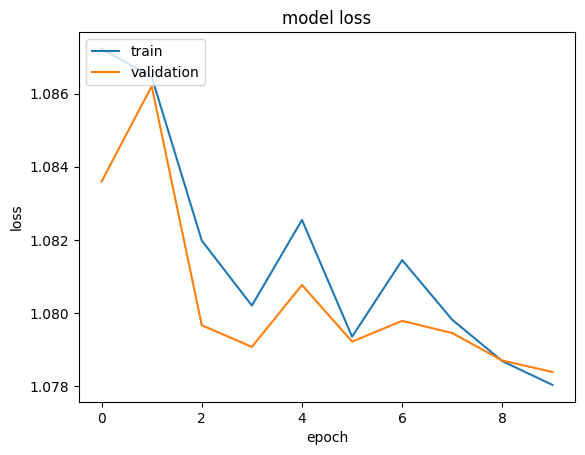

In [10]:
model1 = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history1 = model1.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model1.save_weights("model1.weights.h5")

# Grafik Loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/stepep - accuracy: 0.3302 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3325 - loss: 1.0916 - val_accuracy: 0.3800 - val_loss: 1.0846
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/stepep - accuracy: 0.3501 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 850ms/step - accuracy: 0.3511 - loss: 1.0858 - val_accuracy: 0.3800 - val_loss: 1.0822
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/stepep - accuracy: 0.3935 - loss
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 914ms/step - accuracy: 0.3930 - loss: 1.0882 - val_accuracy: 0.3800 - val_loss: 1.0796
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/stepep - accuracy: 0.3466 - loss: 
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 917ms/step - accuracy: 0.3468 - loss: 1.0741 - val_accuracy: 0.3800 - val_loss: 1.0771
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/stepep - accuracy: 0.3967 - loss: 
Epoch 5 - F1 Score: 0.21

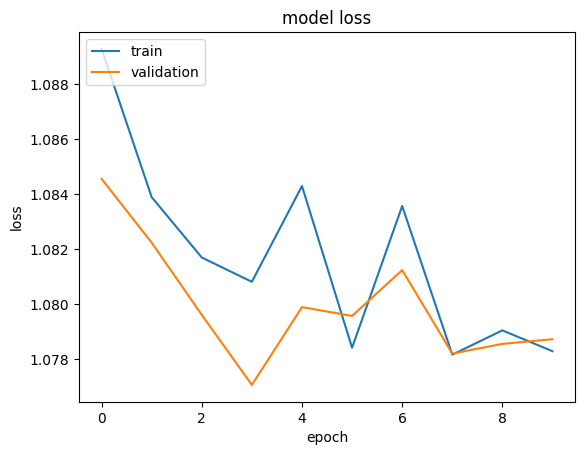

In [11]:
model2 = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history2 = model2.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model2.save_weights("model2.weights.h5")

# Grafik Loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step   - accuracy: 0.3873 - loss:
Epoch 1 - F1 Score: 0.2404

16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3861 - loss: 1.0925 - val_accuracy: 0.3800 - val_loss: 1.0812
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step- accuracy: 0.3855 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3856 - loss: 1.0821 - val_accuracy: 0.3800 - val_loss: 1.0751
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step- accuracy: 0.4187 - loss
Epoch 3 - F1 Score: 0.2557

16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4178 - loss: 1.0657 - val_accuracy: 0.2900 - val_loss: 1.2591
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step- accuracy: 0.4601 - loss
Epoch 4 - F1 Score: 0.4554

16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4603 - loss: 1.0289 - val_accuracy: 0.4900 - val_loss: 1.0233
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step- accuracy: 0.4854 - loss
Epoch 5 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━

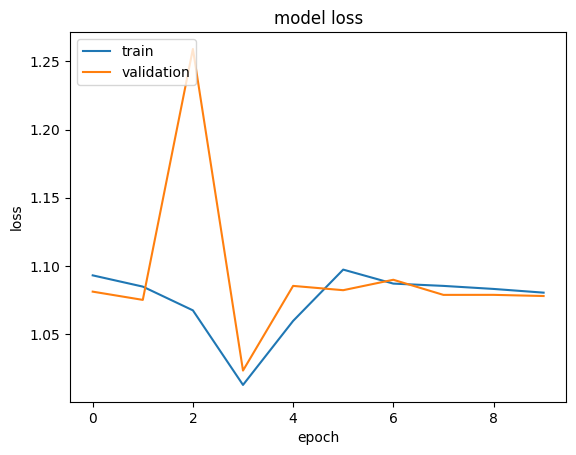

In [12]:
model3 = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history3 = model3.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model3.save_weights("model3.weights.h5")

# Grafik Loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model4 = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(512, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model4.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history4 = model4.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model4.save_weights("model4.weights.h5")

# Grafik Loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 734ms/step- accuracy: 0.4284 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.4265 - loss: 1.0938 - val_accuracy: 0.3800 - val_loss: 1.0803
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step- accuracy: 0.3683 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3676 - loss: 1.0872 - val_accuracy: 0.3800 - val_loss: 1.0794
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step- accuracy: 0.4045 - loss
Epoch 3 - F1 Score: 0.3522

16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4019 - loss: 1.0619 - val_accuracy: 0.4400 - val_loss: 1.0870
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step- accuracy: 0.3501 - loss
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3507 - loss: 1.1510 - val_accuracy: 0.3800 - val_loss: 1.0807
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step- accuracy: 0.3748 - loss
Epoch 5 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/stepep - accuracy: 0.3464 - loss: 
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 668ms/step - accuracy: 0.3480 - loss: 1.0994 - val_accuracy: 0.3800 - val_loss: 1.0802
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/steptep - accuracy: 0.3906 - loss: 1.
Epoch 2 - F1 Score: 0.2425

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.3902 - loss: 1.0755 - val_accuracy: 0.3600 - val_loss: 1.0782
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step ep - accuracy: 0.4197 - loss: 1.
Epoch 3 - F1 Score: 0.3268

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.4196 - loss: 1.0721 - val_accuracy: 0.4100 - val_loss: 1.0603
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step ep - accuracy: 0.4170 - loss: 1.
Epoch 4 - F1 Score: 0.3918

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - accuracy: 0.4190 - loss: 1.0645 - val_accuracy: 0.4600 - val_loss: 1.0147
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/stepep - accuracy: 0.4647 - loss
Epoch 5 - F1 Sc

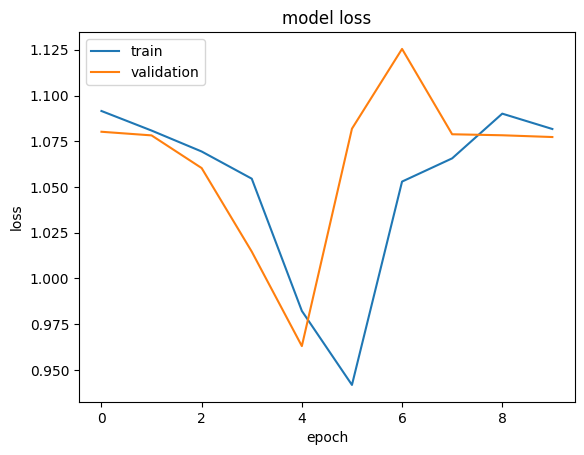

In [ ]:
model5 = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    
    keras.layers.Dense(3, activation="softmax")
])

model5.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history5 = model5.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model5.save_weights("model5.weights.h5")

# Grafik Loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/stepep - accuracy: 0.3548 - loss
Epoch 1 - F1 Score: 0.3244

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 884ms/step - accuracy: 0.3551 - loss: 1.0913 - val_accuracy: 0.4200 - val_loss: 1.0869
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/stepep - accuracy: 0.4001 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 616ms/step - accuracy: 0.3989 - loss: 1.0870 - val_accuracy: 0.3800 - val_loss: 1.0802
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/stepep - accuracy: 0.3719 - loss:
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 585ms/step - accuracy: 0.3723 - loss: 1.0882 - val_accuracy: 0.3800 - val_loss: 1.0825
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/stepep - accuracy: 0.3971 - loss
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 576ms/step - accuracy: 0.3958 - loss: 1.0793 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/stepep - accuracy: 0.4092 - loss
Epoch 5 - F1 Score: 0.2093


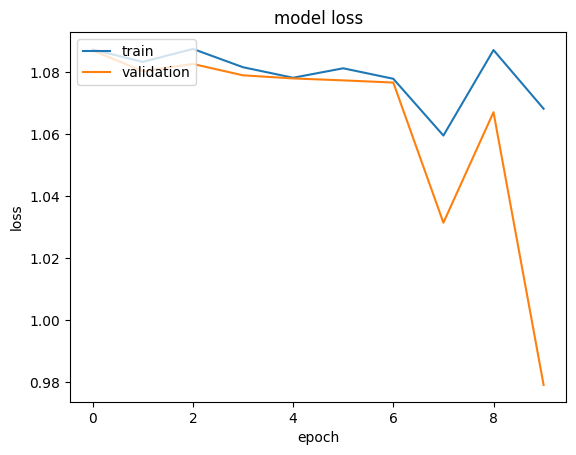

In [ ]:
model6 = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(512),
    
    keras.layers.Dense(3, activation="softmax")
])

model6.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history6 = model6.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model6.save_weights("model6.weights.h5")

# Grafik Loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/stepep - accuracy: 0.3703 - loss: 1
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 464ms/step - accuracy: 0.3714 - loss: 1.0873 - val_accuracy: 0.3800 - val_loss: 1.0823
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/steptep - accuracy: 0.3822 - loss: 1.0
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.3823 - loss: 1.0807 - val_accuracy: 0.3800 - val_loss: 1.0814
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step ep - accuracy: 0.3747 - loss: 1.
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.3747 - loss: 1.0778 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/stepep - accuracy: 0.3673 - loss: 1
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.3674 - loss: 1.0736 - val_accuracy: 0.3800 - val_loss: 1.0797
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/steptep - accuracy: 0.3990 - loss: 1.0
Epoch 5 -

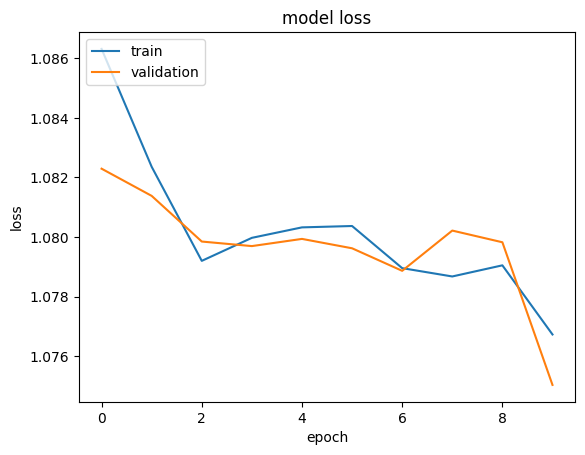

In [ ]:
model7 = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    
    keras.layers.Dense(3, activation="softmax")
])

model7.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history7 = model7.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model7.save_weights("model7.weights.h5")

# Grafik Loss
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/stepep - accuracy: 0.4253 - loss: 
Epoch 1 - F1 Score: 0.3380

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 460ms/step - accuracy: 0.4254 - loss: 1.0759 - val_accuracy: 0.4300 - val_loss: 1.0281
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/steptep - accuracy: 0.5041 - loss: 0.9
Epoch 2 - F1 Score: 0.4795

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.5049 - loss: 0.9884 - val_accuracy: 0.5200 - val_loss: 0.9651
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/steptep - accuracy: 0.4709 - loss: 0.9
Epoch 3 - F1 Score: 0.4853

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.4723 - loss: 0.9563 - val_accuracy: 0.5400 - val_loss: 0.9854
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/steptep - accuracy: 0.5633 - loss: 0.9
Epoch 4 - F1 Score: 0.4909

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.5622 - loss: 0.9172 - val_accuracy: 0.5000 - val_loss: 0.9339
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/stepep - accuracy: 0.5779 - loss: 
Epoch 5 - 

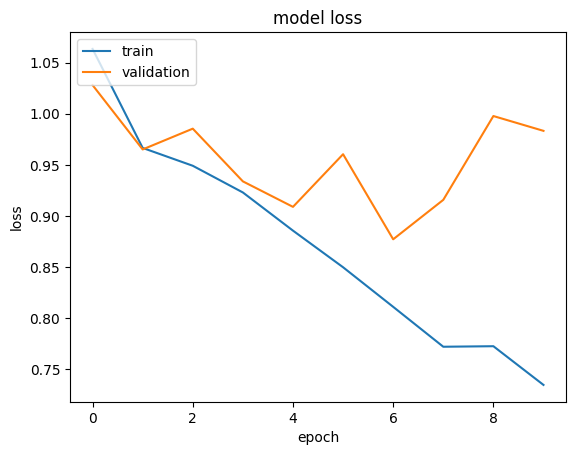

In [ ]:
model8 = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    
    keras.layers.Dense(3, activation="softmax")
])

model8.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history8 = model8.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model8.save_weights("model8.weights.h5")

# Grafik Loss
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()